In [1]:
from __future__ import absolute_import, division, print_function, unicode_literals

# TensorFlow and tf.keras
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import ProgbarLogger, TensorBoard, LambdaCallback

# Helper libraries
import numpy as np
import matplotlib.pyplot as plt
import datetime
from io import StringIO

print(tf.__version__)

2.1.0


In [18]:
from GPyOpt.methods import BayesianOptimization

In [2]:
fashion_mnist = keras.datasets.fashion_mnist

(train_images, train_labels), (test_images, test_labels) = fashion_mnist.load_data()

train_images = train_images / 255.0
test_images = test_images / 255.0

In [3]:
img_rows, img_cols = (28, 28)
train_images = train_images.reshape(train_images.shape[0], img_rows, img_cols, 1)
test_images = test_images.reshape(test_images.shape[0], img_rows, img_cols, 1)
input_shape = (img_rows, img_cols, 1)
half_validate = round(test_images.shape[0] / 2)

In [4]:
test_labels

array([9, 2, 1, ..., 8, 1, 5], dtype=uint8)

In [5]:
logdir = "logs/scalars/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
file_writer = tf.summary.create_file_writer(logdir + "/metrics")
file_writer.set_as_default()

In [6]:
def get_model_dense():
    model = keras.Sequential([
        keras.layers.Flatten(input_shape=(28, 28, 1)),
        keras.layers.Dense(128, activation='relu'),
        keras.layers.Dense(10, activation='softmax')
    ])
    return model
def get_model_dense2():
    model = keras.Sequential([
        keras.layers.Flatten(input_shape=(28, 28, 1)),
        keras.layers.Dense(10, activation='softmax')
    ])
    return model
def get_model_dense3():
    model = keras.Sequential([
        keras.layers.Flatten(input_shape=(28, 28, 1)),
        keras.layers.Dense(400, activation='relu'),
        keras.layers.Dense(128, activation='relu'),
        keras.layers.Dense(10, activation='softmax')
    ])
    return model

In [7]:
def get_model_basic_conv():
    model = keras.Sequential([
        keras.layers.Conv2D(32, (3, 3), activation='relu', input_shape=input_shape),
        keras.layers.Flatten(),
        keras.layers.Dense(128, activation='relu'),
        keras.layers.Dense(10, activation='softmax')
    ])
    return model

In [27]:
def get_model_basic_conv2():
    model = keras.Sequential([
        keras.layers.Conv2D(32, (3, 3), activation='relu', input_shape=input_shape),
        keras.layers.MaxPool2D(pool_size=(2, 2)),
        keras.layers.Flatten(),
        keras.layers.Dense(10, activation='softmax')
    ])
    return model

In [9]:
def get_model_basic_conv3():
    model = keras.Sequential([
        keras.layers.Conv2D(32, (3, 3), activation='relu', input_shape=input_shape),
        keras.layers.Flatten(),
        keras.layers.Dense(400, activation='relu'),
        keras.layers.Dense(128, activation='relu'),
        keras.layers.Dense(10, activation='softmax')
    ])
    return model

In [10]:
def get_model_basic_rand():
    model = keras.Sequential([
        keras.layers.Conv2D(32, (3, 3), activation='relu', input_shape=input_shape),
        keras.layers.MaxPool2D(pool_size=(2, 2)),
        keras.layers.Flatten(),
        keras.layers.Dense(128, activation='relu', trainable=False),
        keras.layers.Dense(10, activation='softmax')
    ])
    return model

In [28]:
def get_model_basic_rand2():
    model = keras.Sequential([
        keras.layers.Conv2D(32, (3, 3), activation='relu', input_shape=input_shape),
        keras.layers.MaxPool2D(pool_size=(2, 2)),
        keras.layers.Flatten(),
        keras.layers.Dense(1280, activation='relu', trainable=False),
        keras.layers.Dense(10, activation='softmax')
    ])
    return model

In [32]:
model = keras.Sequential([
        keras.layers.Conv2D(32, (4, 4), activation='relu', input_shape=input_shape),
        keras.layers.MaxPool2D(pool_size=(2, 2)),
        keras.layers.Flatten(),
        keras.layers.Dense(1280, activation='relu', trainable=False),
        keras.layers.Dense(10, activation='softmax')
    ])
model.build()
model.summary()

Model: "sequential_11"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_11 (Conv2D)           (None, 25, 25, 32)        544       
_________________________________________________________________
max_pooling2d_11 (MaxPooling (None, 12, 12, 32)        0         
_________________________________________________________________
flatten_11 (Flatten)         (None, 4608)              0         
_________________________________________________________________
dense_17 (Dense)             (None, 1280)              5899520   
_________________________________________________________________
dense_18 (Dense)             (None, 10)                12810     
Total params: 5,912,874
Trainable params: 13,354
Non-trainable params: 5,899,520
_________________________________________________________________


In [12]:
def get_model_basic_rand3():
    model = keras.Sequential([
        keras.layers.Conv2D(32, (3, 3), activation='relu', input_shape=input_shape),
        keras.layers.MaxPool2D(pool_size=(2, 2), strides=(1, 1), padding='valid'),
        keras.layers.Flatten(),
        keras.layers.Dense(400, activation='relu', trainable=False),
        keras.layers.Dense(400, activation='relu', trainable=False),
        keras.layers.Dense(400, activation='relu', trainable=False),
        keras.layers.Dense(400, activation='relu', trainable=False),
        keras.layers.Dense(400, activation='relu', trainable=False),
        keras.layers.Dense(400, activation='relu', trainable=False),
        keras.layers.Dense(400, activation='relu', trainable=False),
        keras.layers.Dense(128, activation='relu'),
        keras.layers.Dense(10, activation='softmax')
    ])
    return model

In [20]:
def log_space(x, shift=1e-12): return np.log(x + shift)
def un_log_space(x, shift=1e-12): return np.exp(x) - shift

In [120]:
domain = [
    {
        "name": "nr_convolutions",
        "type": "continuous",
        "domain": (log_space(4, shift=1), log_space(100, shift=1)),
    },
    {
        "name": "convolution_size",
        "type": "continuous",
        "domain": (2, 7),
    },
#     {
#         "name": "convolution_strides",
#         "type": "continuous",
#         "domain": (2, 5),
#     },
#     {
#         "name": "maxpool_size",
#         "type": "continuous",
#         "domain": (2, 7),
#     },
#     {
#         "name": "maxpool_strides",
#         "type": "continuous",
#         "domain": (2, 7),
#     },
    {
        "name": "random_layer_size",
        "type": "continuous",
        "domain": (log_space(4, shift=1), log_space(128, shift=1)),
    },
    {
        "name": "after_layer_size",
        "type": "continuous",
        "domain": (log_space(3, shift=1), log_space(100, shift=1)),
    },
]
len(domain)

4

In [98]:
def compile(*values, sep=" "):
    return sep.join(map(str, values))

In [99]:
def pars(*values):
    return "(" + compile(*values) + ")"

In [100]:
def f_normal(index):
    return "x[:, {}]".format(index)

In [101]:
def f_ul(index, shift=1):
    return compile("(np.exp(", f_normal(index), ") - ", shift, ")", sep="")

In [102]:
def f_round(v):
    return "np.round(" + str(v) + ")"

In [121]:
after_max_pool = compile(
    "np.floor", pars(pars(28, "-", pars(f_round(f_normal(1)), "-", 1)), "/", 2), "**", 2,
    "*",
    f_round(f_ul(0)),
)
nr_trainable_weights = compile(
    pars(f_round(f_ul(0)), "**", 2, "+", 1), "*", f_round(f_ul(1)),
    "+",
#     after_max_pool, "*", f_round(f_ul(2)),
#     "+",
    pars(f_round(f_ul(2)), "+", 1), "*", f_round(f_ul(3)),
    "+",
    pars(f_round(f_ul(3)), "+", 1), "*", 10,
)

In [122]:
nr_trainable_weights


'(np.round((np.exp(x[:, 0]) - 1)) ** 2 + 1) * np.round((np.exp(x[:, 1]) - 1)) + (np.round((np.exp(x[:, 2]) - 1)) + 1) * np.round((np.exp(x[:, 3]) - 1)) + (np.round((np.exp(x[:, 3]) - 1)) + 1) * 10'

In [123]:
constraints = [
    {
        "name": "max_trainable_weights",
        "constraint": compile(nr_trainable_weights, "-", 1000),
    },
    {
        "name": "min_trainable_weights",
        "constraint": compile("-", pars(nr_trainable_weights), "+", 500),
    },
]

In [128]:
def build_model(
    nr_convolutions,
    convolution_size,
    random_layer_size,
    after_layer_size,
):
    model = keras.Sequential()
    model.add(keras.layers.InputLayer(input_shape))
    model.add(keras.layers.Conv2D(
        nr_convolutions, 
        (convolution_size, convolution_size), 
#         strides=(convolution_strides, convolution_strides),
        activation='relu',
    ))
    model.add(keras.layers.MaxPool2D(
        pool_size=(2, 2),
#         pool_size=(maxpool_size, maxpool_size), 
#         strides=(maxpool_strides, maxpool_strides),
    ))
    model.add(keras.layers.Flatten())
    
    model.add(keras.layers.Dense(random_layer_size, activation='relu', trainable=False))
    model.add(keras.layers.Dense(after_layer_size, activation='relu'))
    model.add(keras.layers.Dense(10, activation='softmax'))
    
    return model

In [136]:
def test_f(hyperparams):
    config = dict(zip(map(lambda var: var["name"], domain), hyperparams[0]))
    
    for var in [
        "nr_convolutions",
        "random_layer_size",
        "after_layer_size",
    ]: config[var] = un_log_space(config[var])
    for var in config.keys(): config[var] = round(config[var])
    for var in config.keys(): config[var] = int(config[var])
        
    model = build_model(**config)
    model.compile(
            optimizer='adam',
            loss='sparse_categorical_crossentropy',
            metrics=['accuracy']
        )
    model.fit(
        train_images, train_labels,
        64,
        epochs=50,
        shuffle=True,
        validation_data=(test_images[:half_validate], test_labels[:half_validate]),
        callbacks=[
            keras.callbacks.EarlyStopping(
                patience=3,
                min_delta=1e-3,
                restore_best_weights=True,
            ),
        ],
        verbose=0,
    )

    return model.evaluate(
        test_images[half_validate:],
        test_labels[half_validate:],
        verbose=0,
    )[-1]

In [153]:
bo = BayesianOptimization(
    f=test_f,
    X=bo.X, Y=bo.Y,
    domain=domain,
    constraints=constraints,
    maximize=True,
    jitter=.05,
)

In [152]:
bo.X = bo.X[:-1, :]

In [150]:
bo.Y

array([[-0.72399998],
       [-0.58579999],
       [-0.78380001],
       [-0.79119998],
       [-0.7148    ],
       [-0.6322    ]])

In [147]:
bo.Y = - bo.Y

In [154]:
bo.run_optimization()

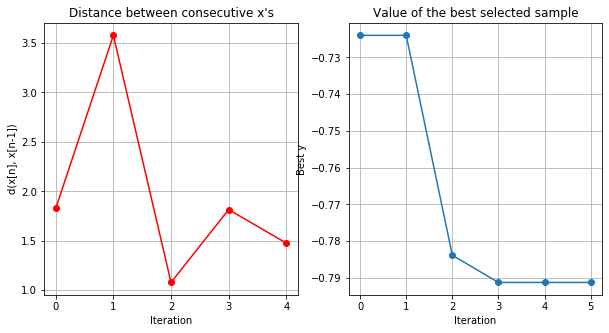

In [155]:
bo.plot_convergence()

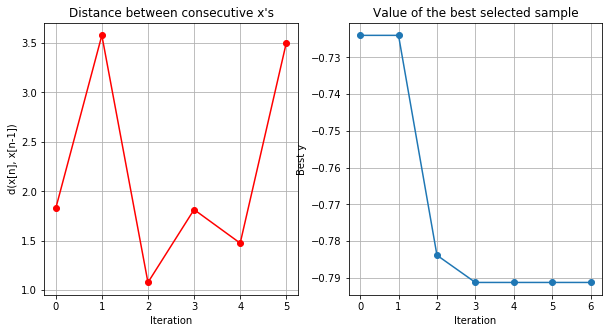

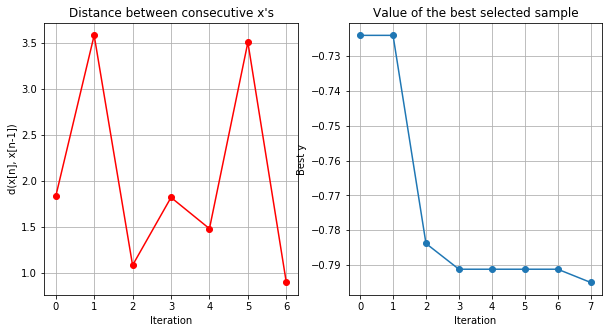

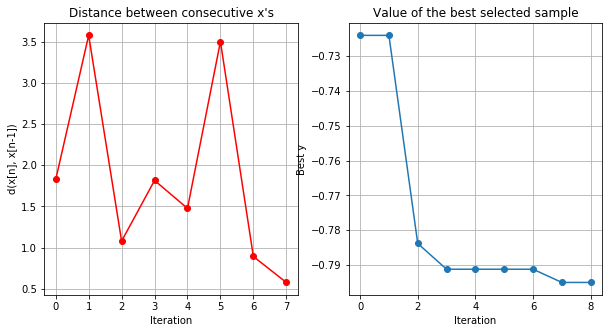

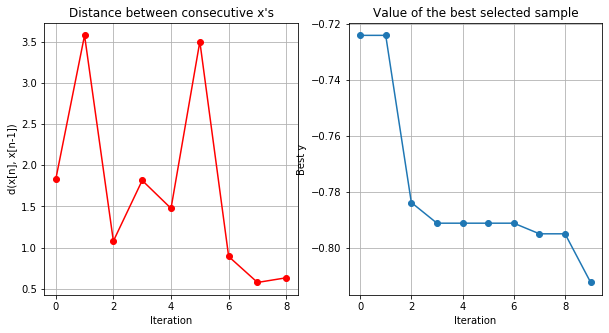

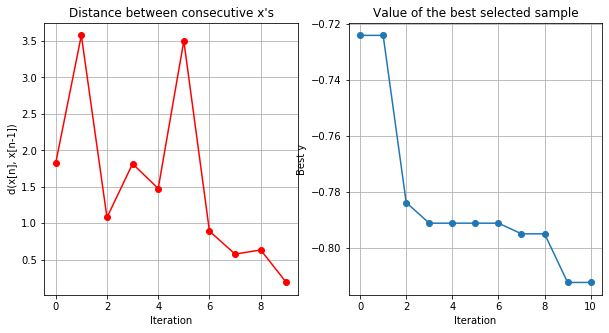

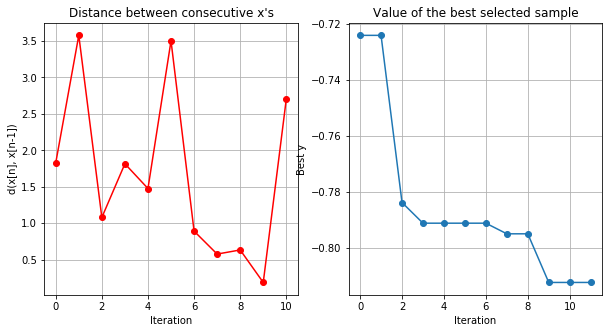

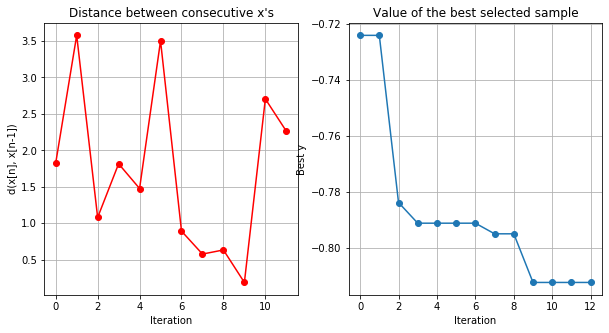

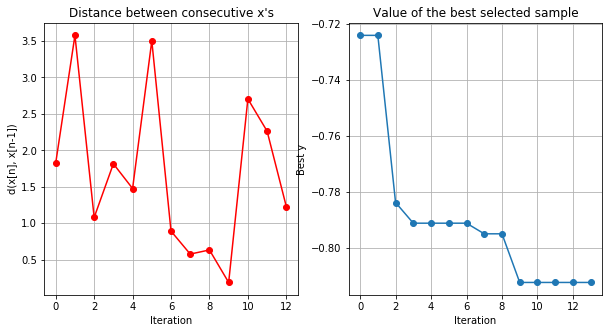

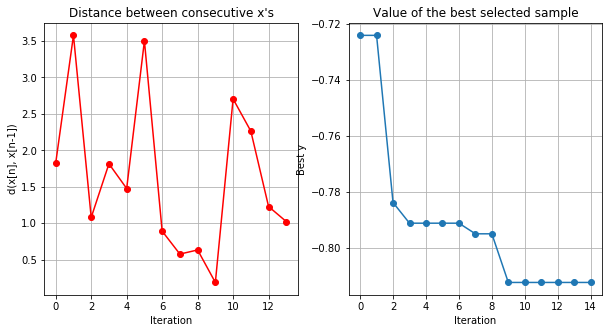

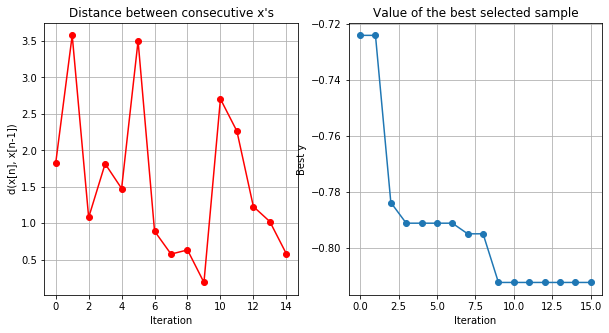

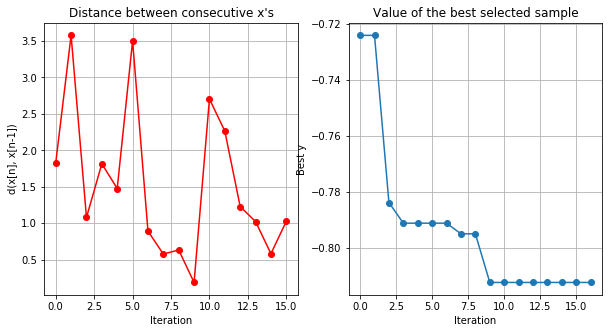

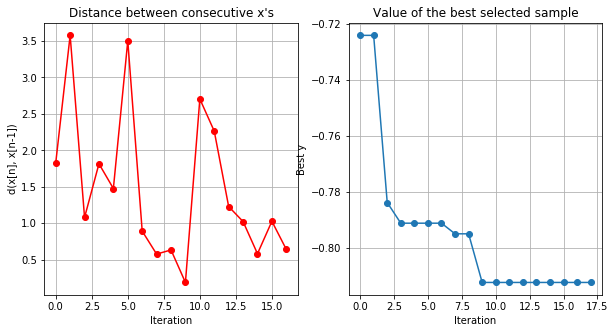

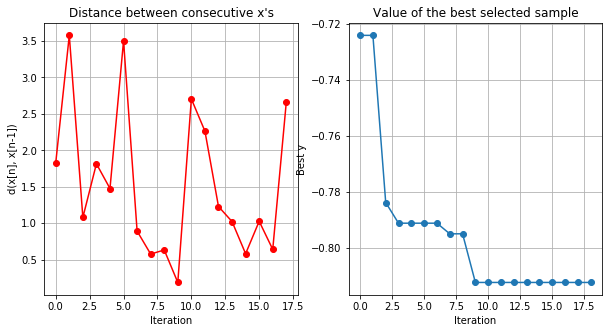

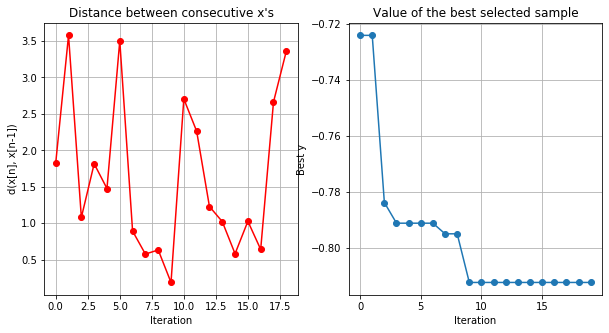

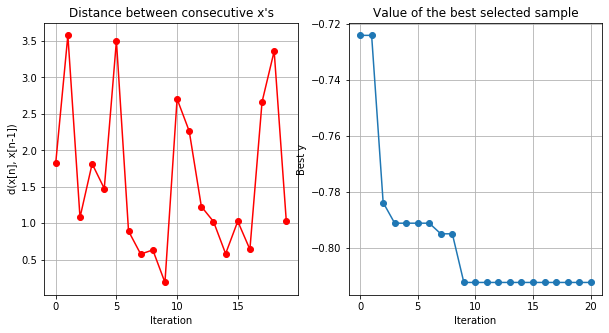

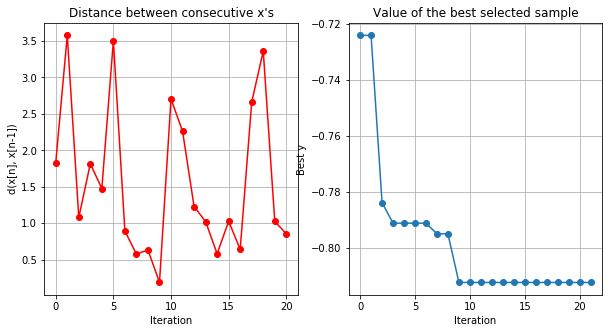

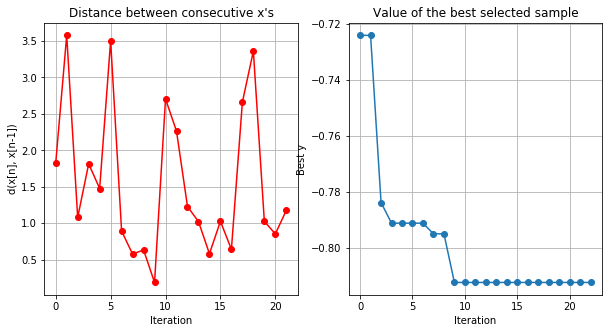

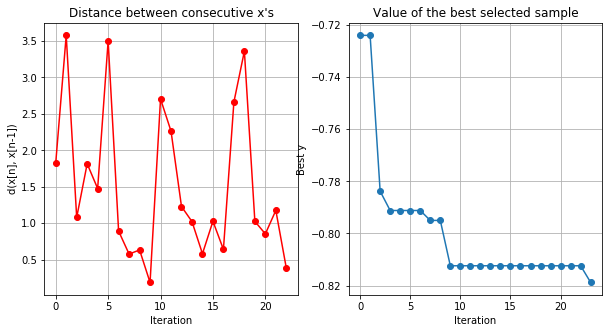

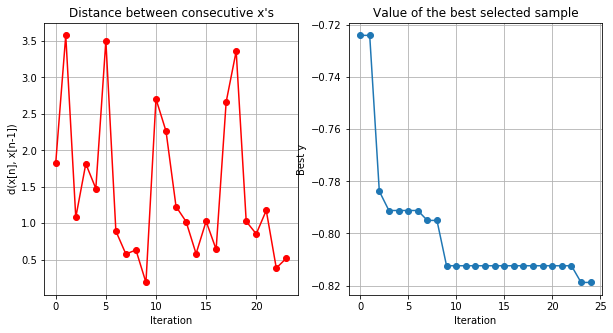

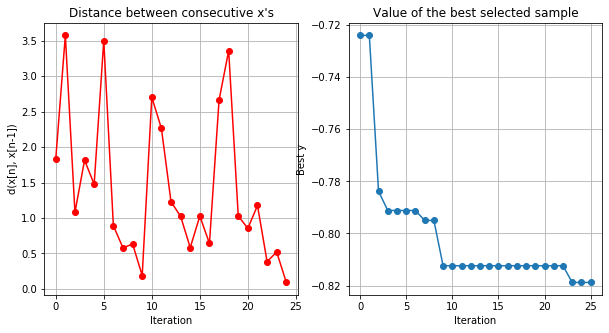

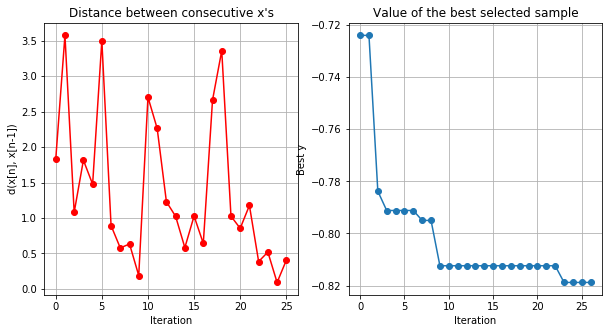

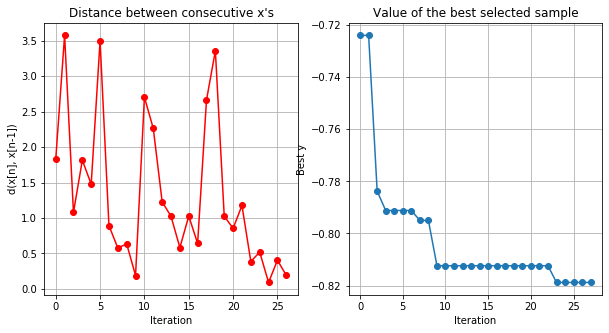

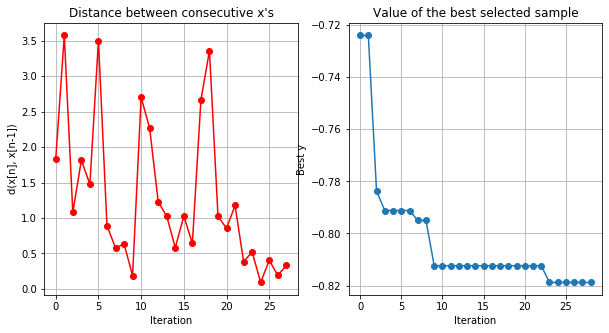

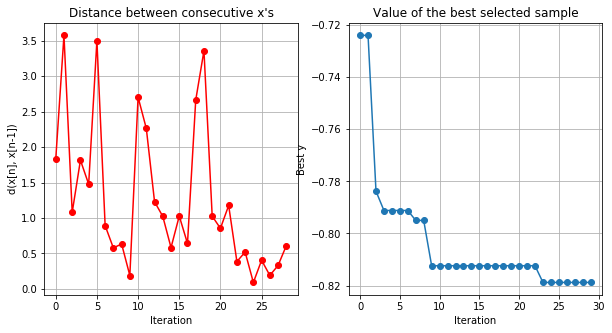

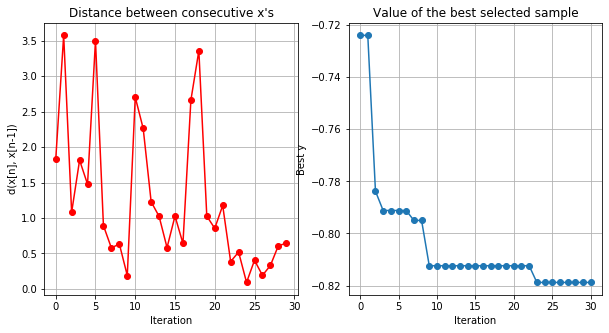

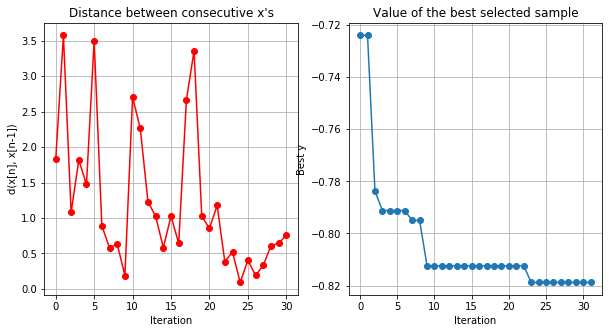

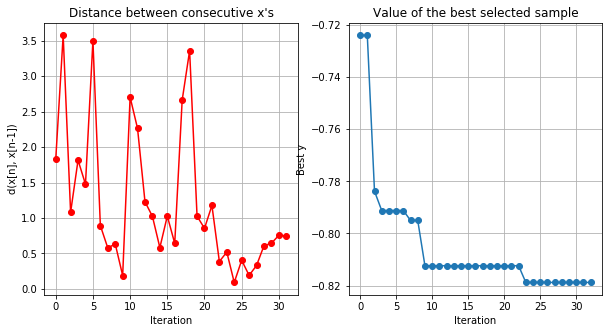

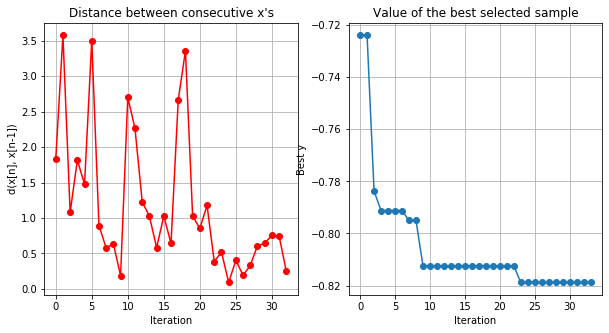

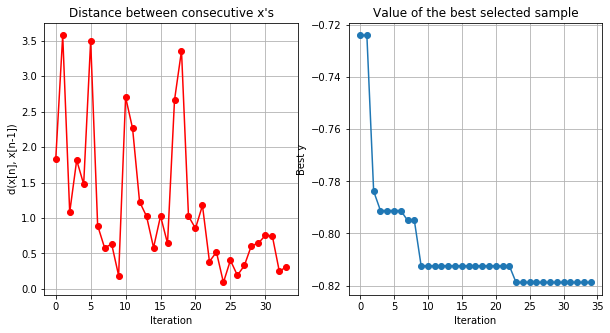

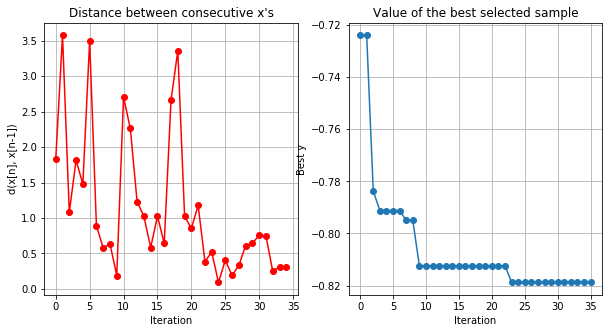

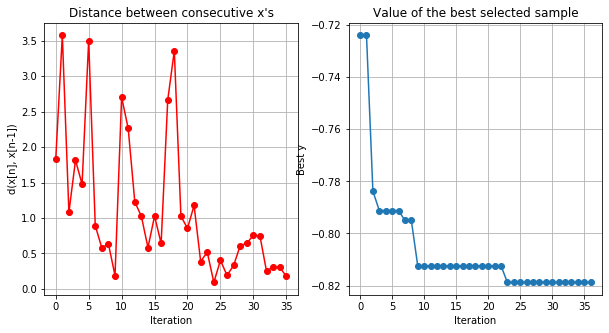

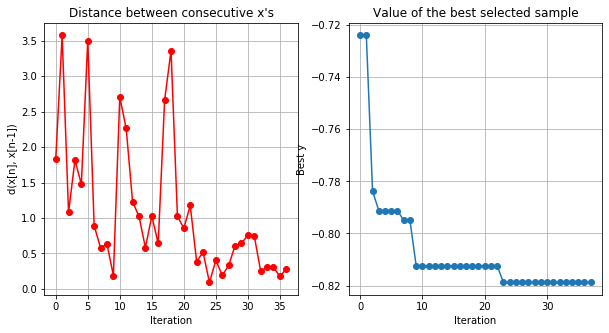

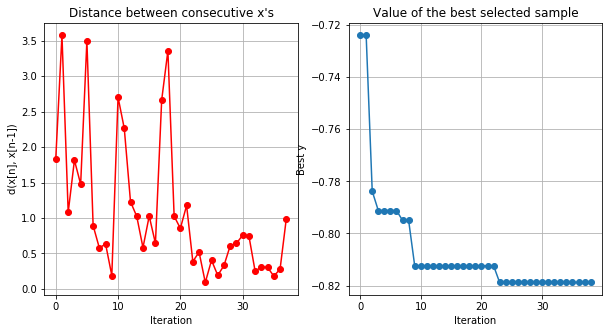

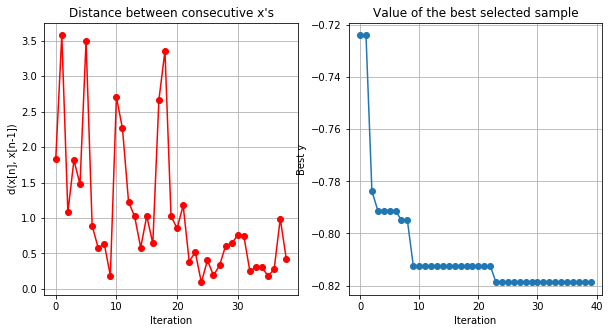

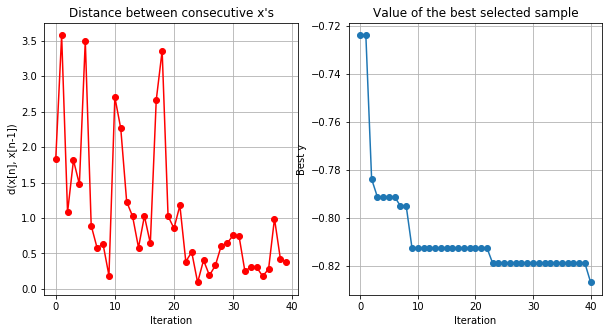

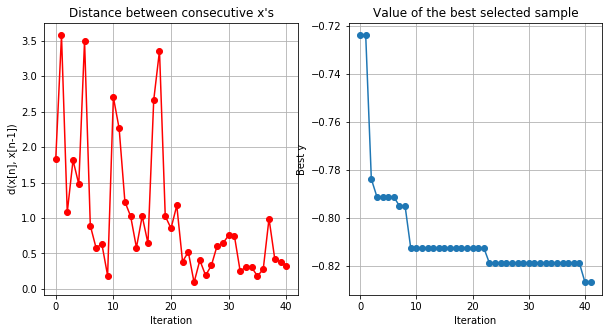

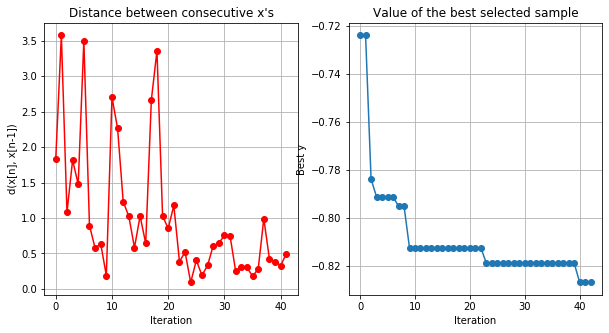

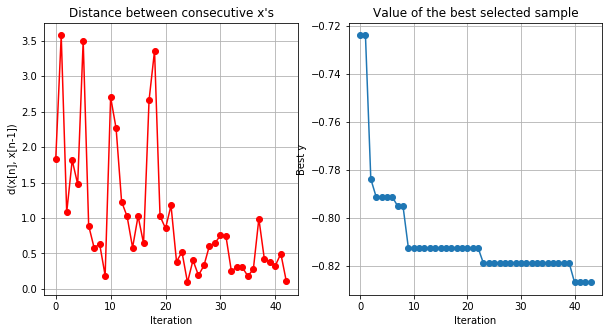

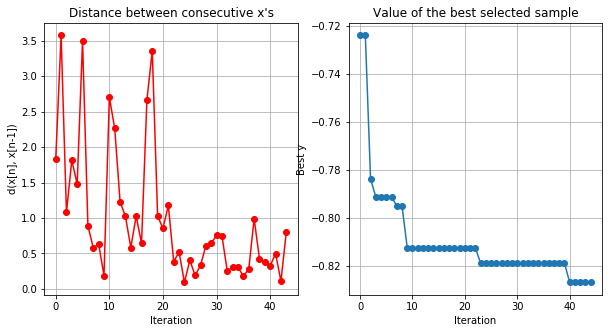

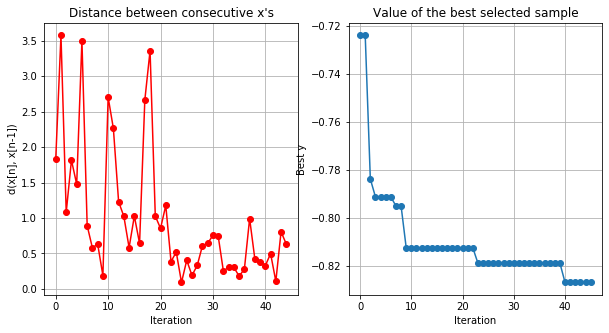

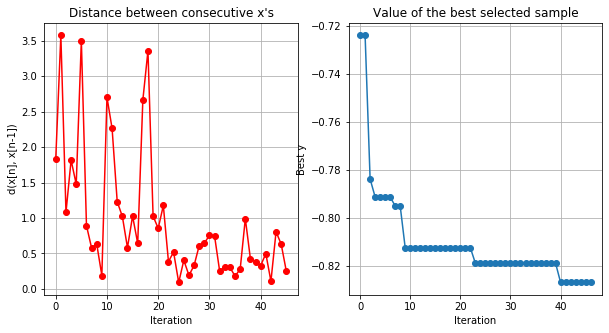

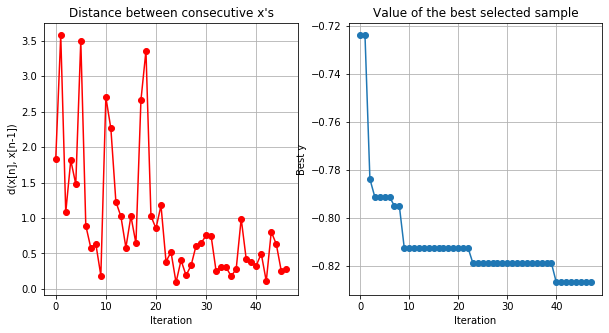

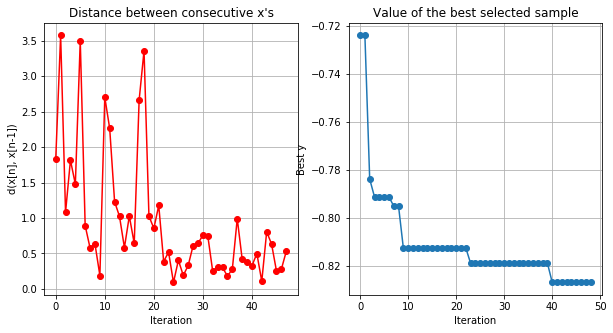

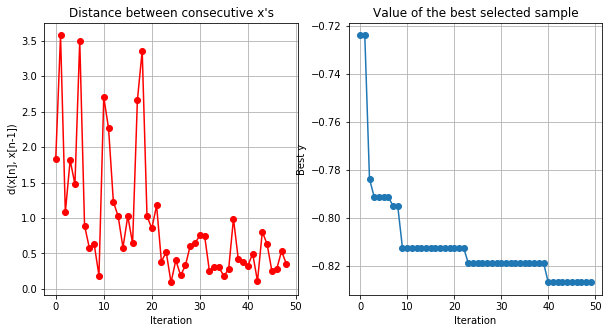

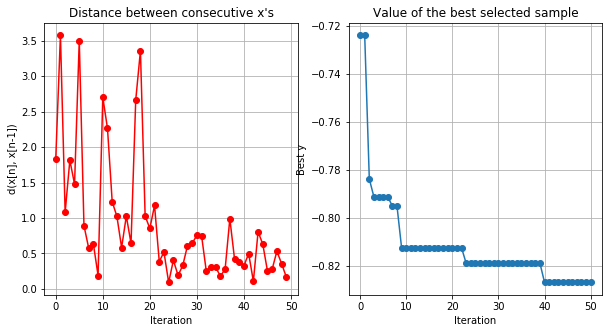

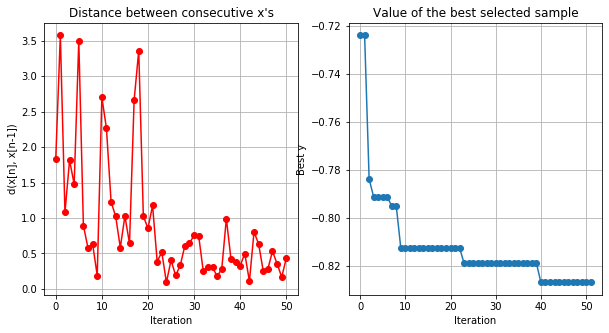

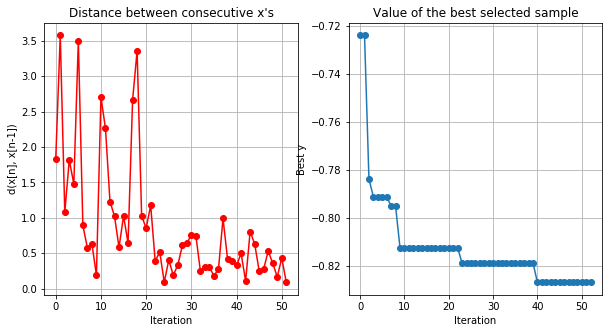

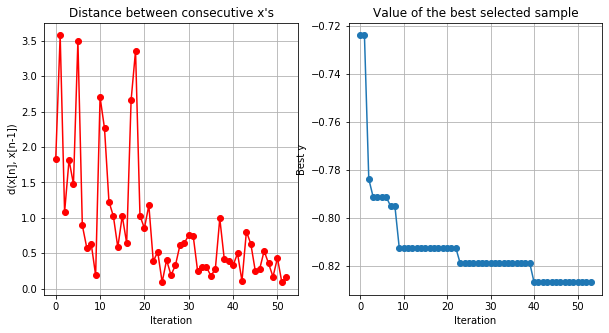

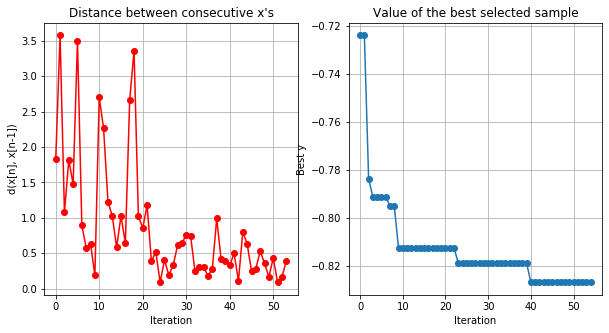

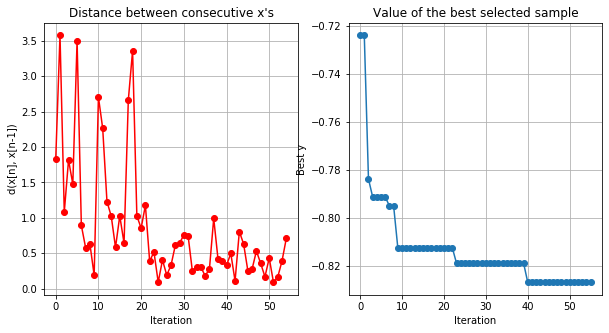

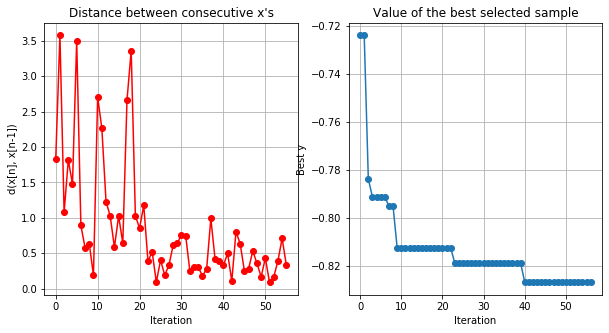

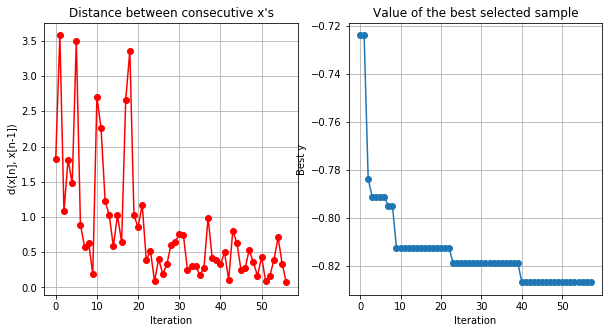

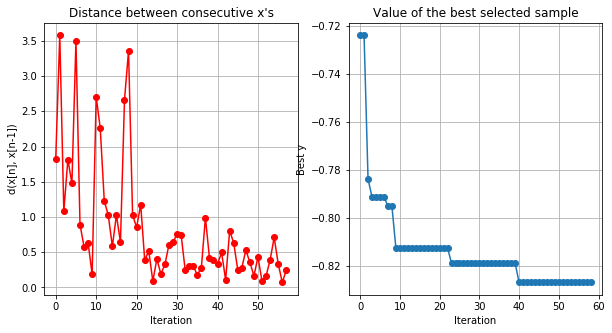

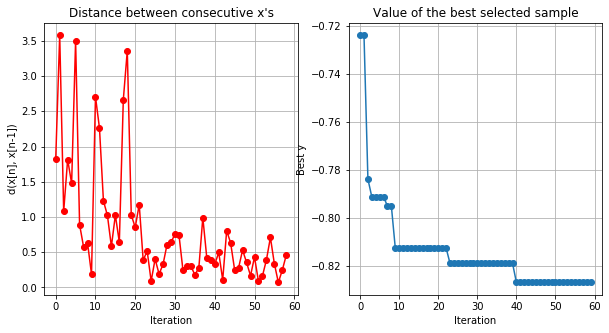

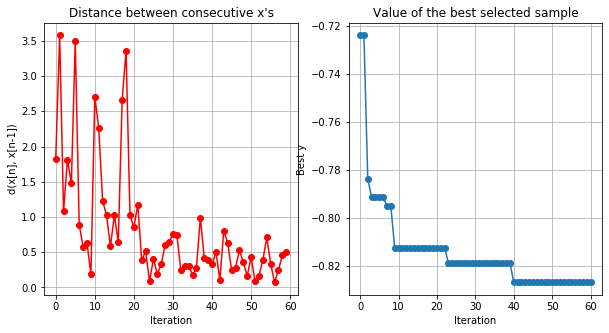

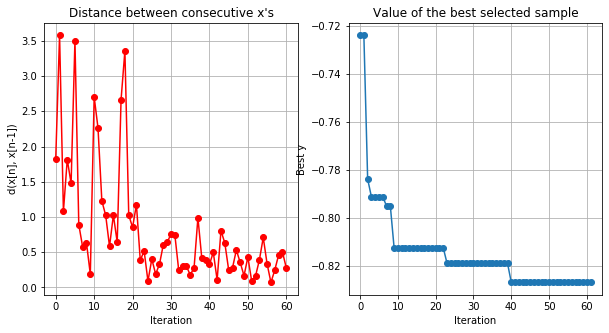

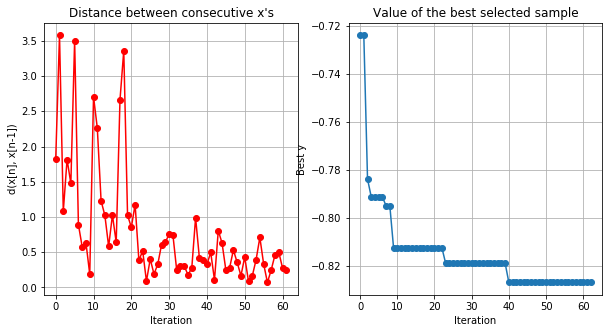

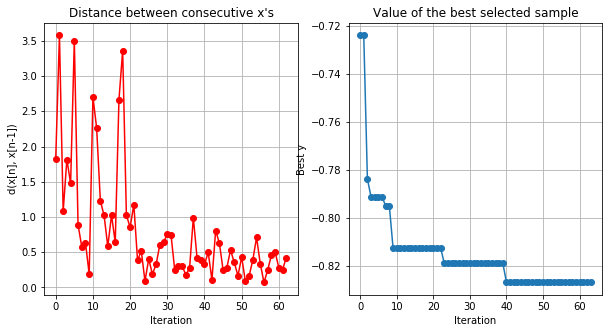

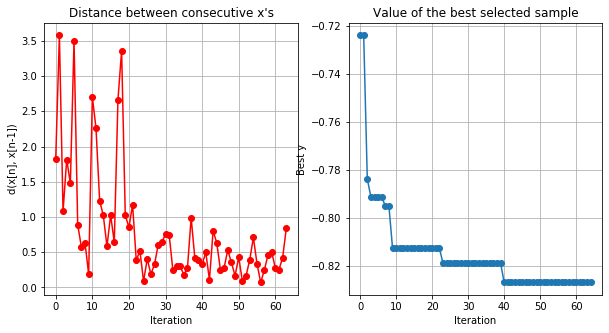

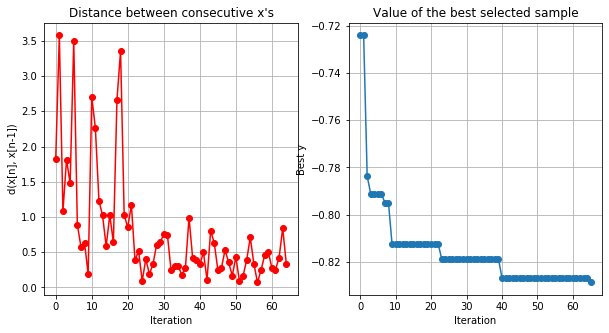

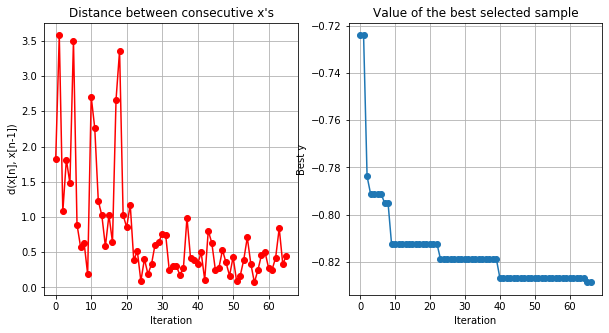

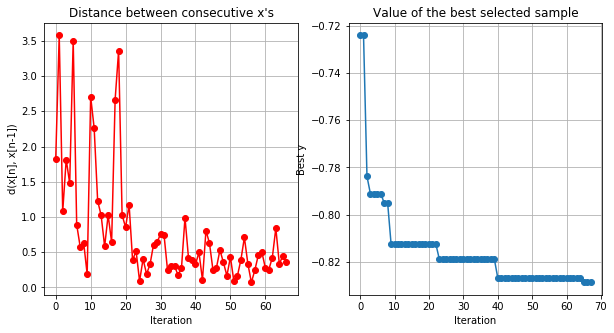

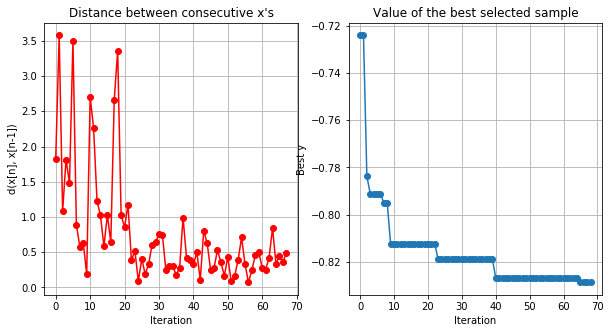

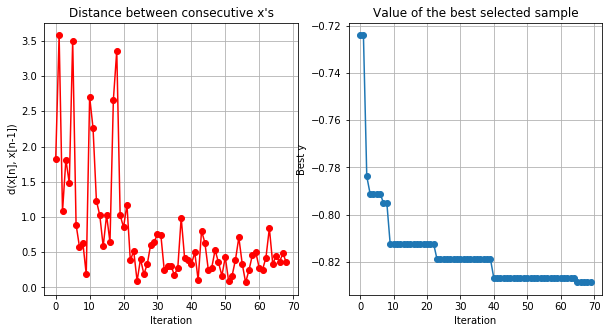

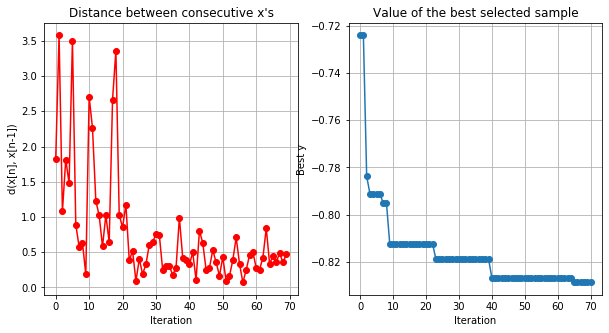

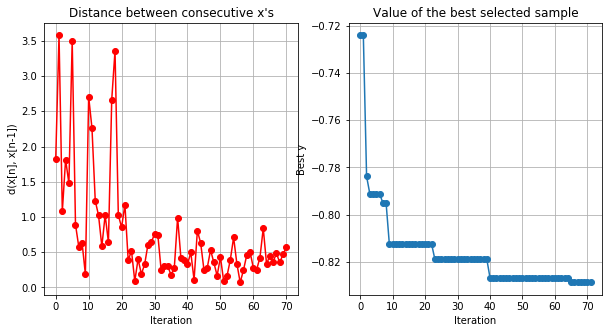

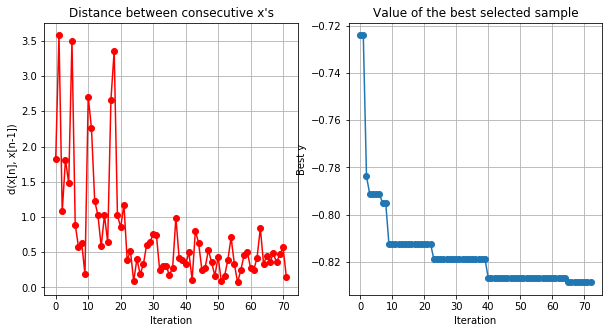

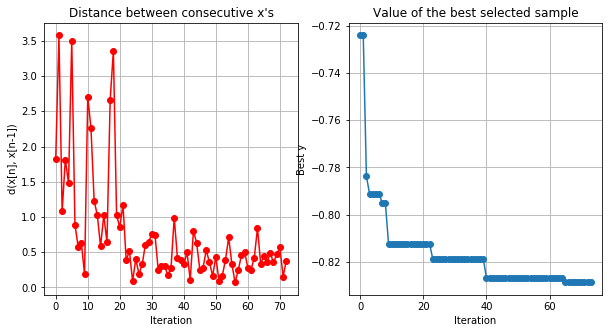

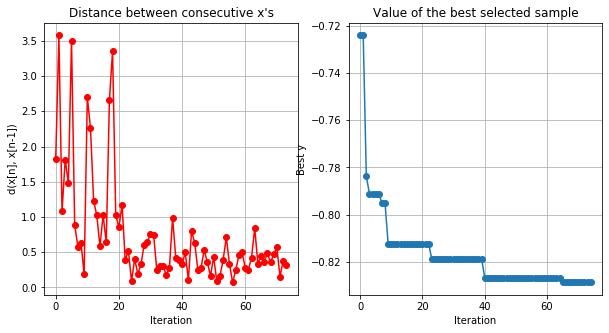

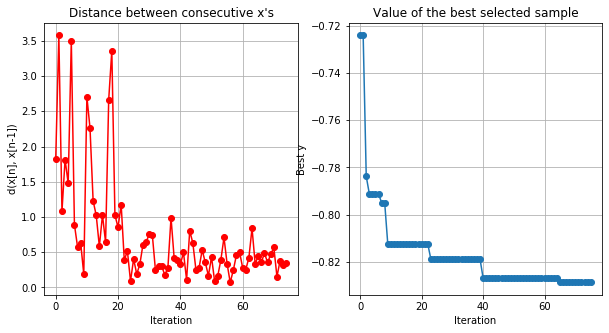

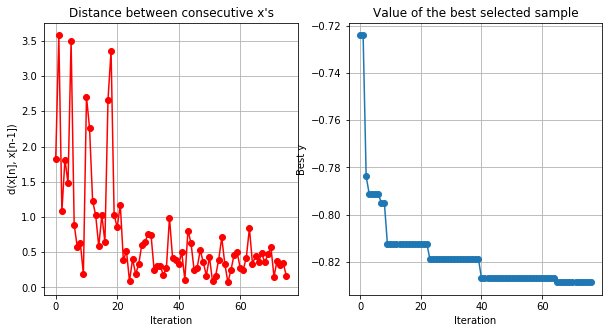

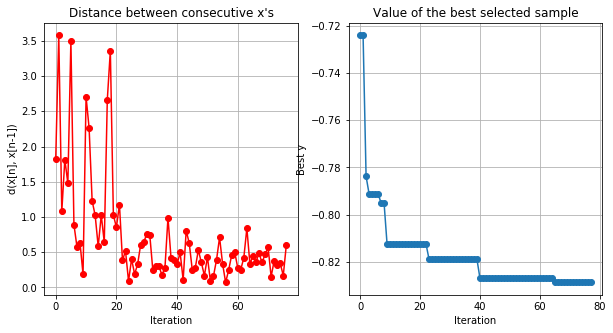

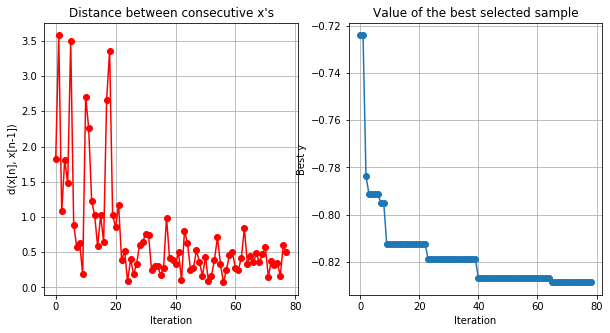

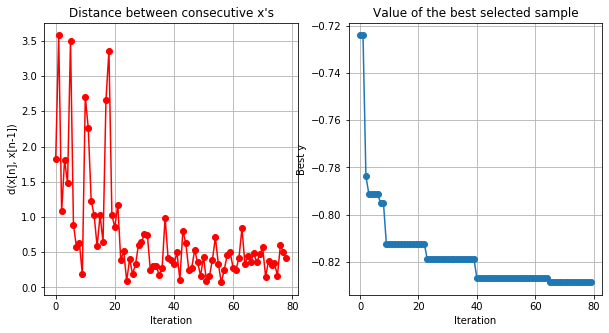

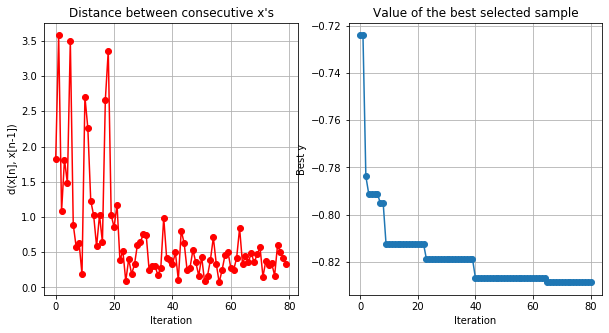

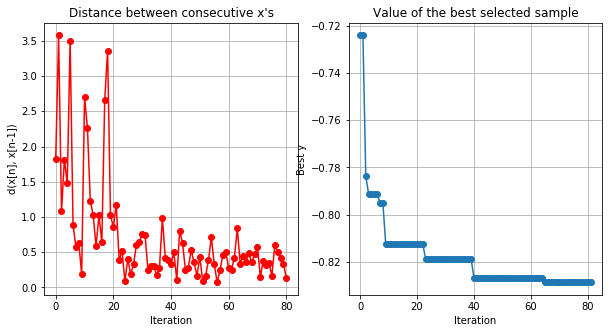

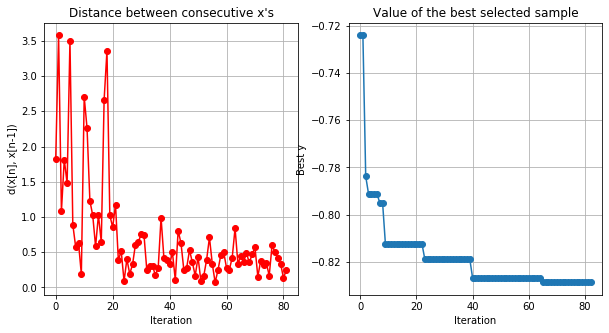

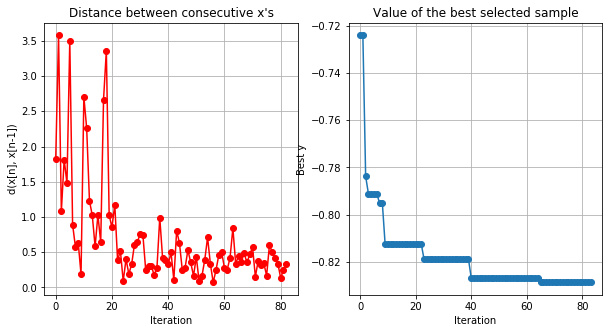

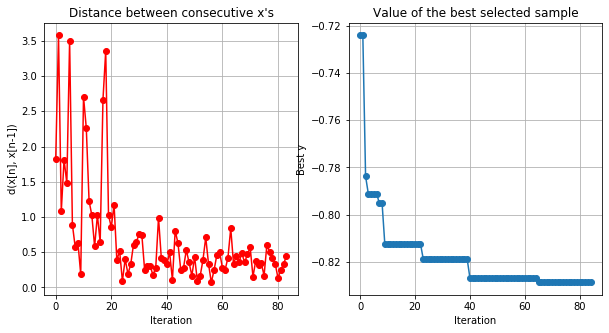

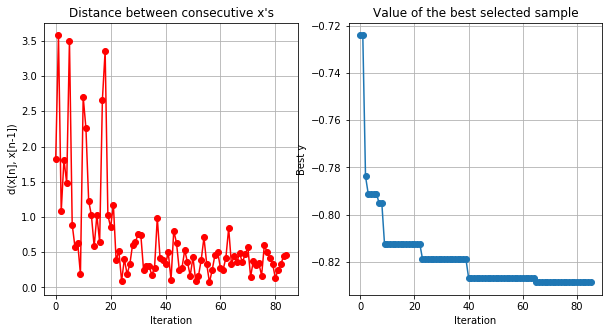

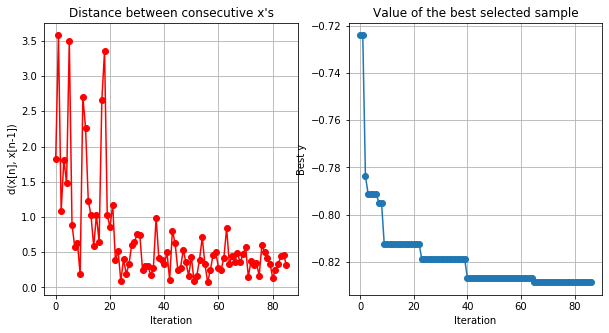

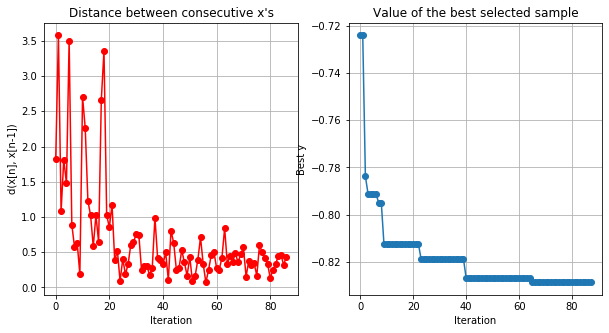

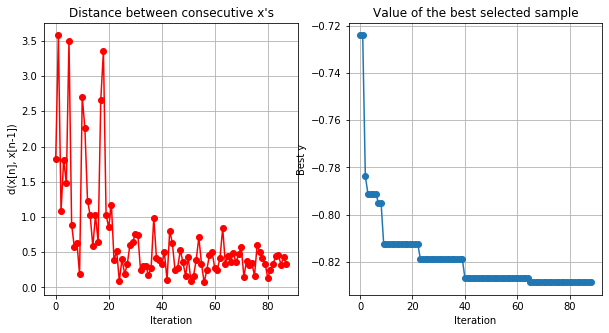

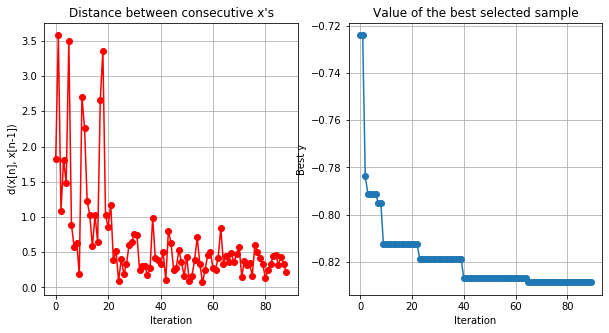

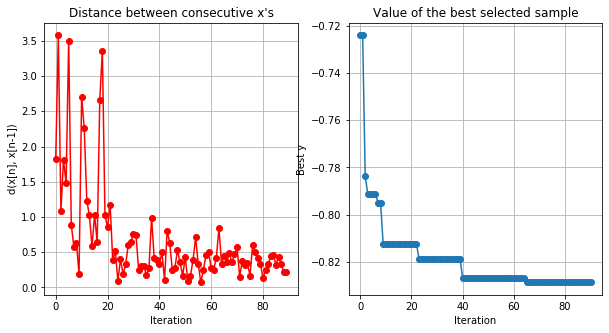

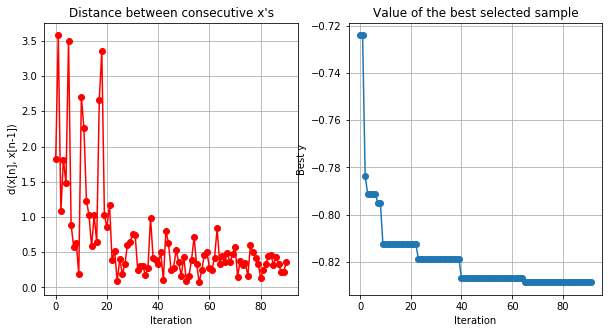

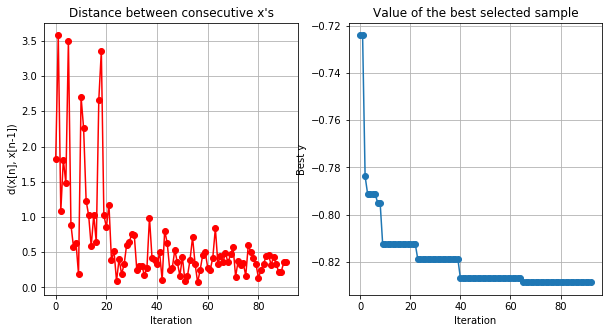

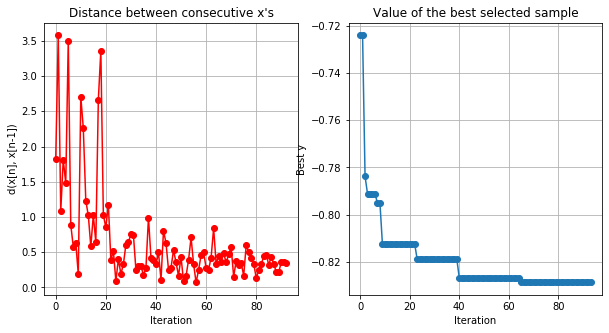

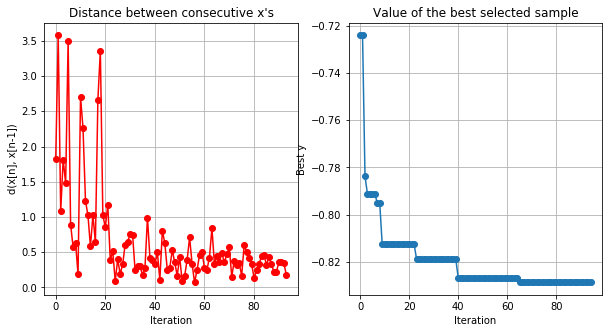

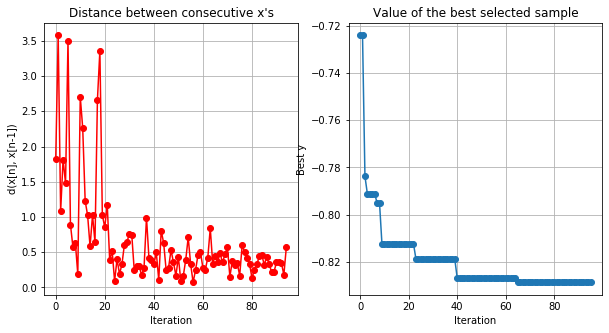

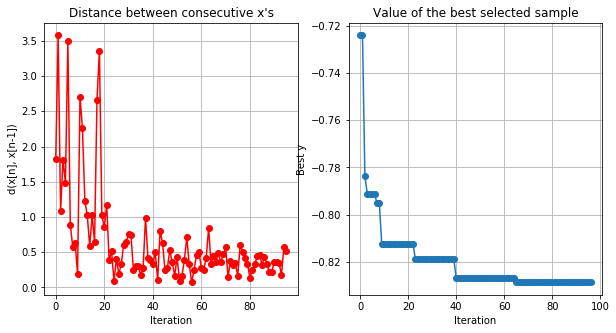

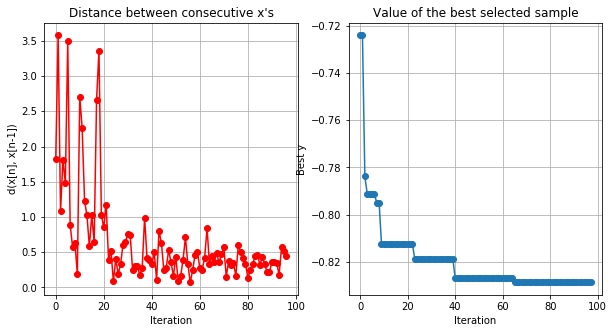

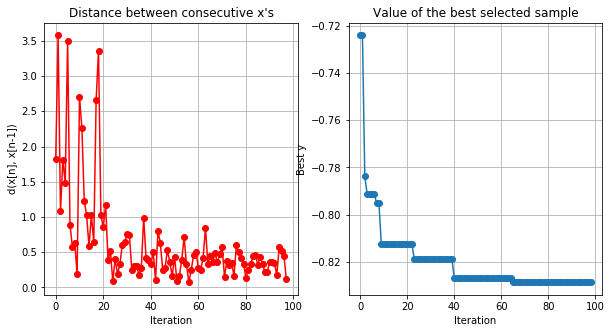

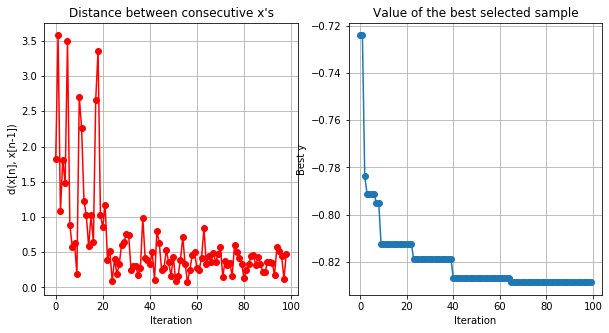

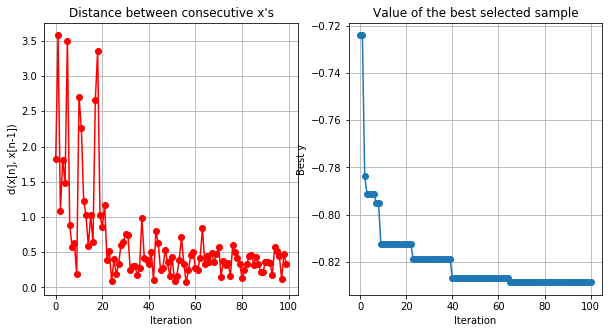

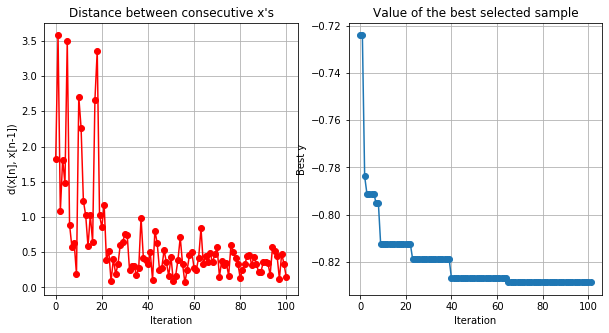

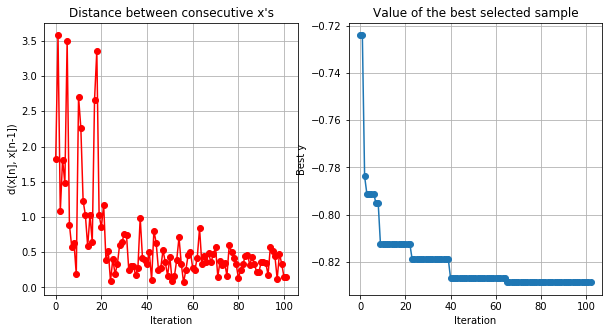

KeyboardInterrupt: 

In [156]:
for _ in range(100):
    bo.run_optimization(1)
    bo.plot_convergence()

In [157]:
best = np.argsort(bo.Y.reshape(-1))[:10]
bo.Y[best]

array([[-0.82880002],
       [-0.82700002],
       [-0.82679999],
       [-0.82480001],
       [-0.8222    ],
       [-0.82059997],
       [-0.82059997],
       [-0.8204    ],
       [-0.81959999],
       [-0.81879997]])

In [160]:
un_logged = np.stack([
    np.round(un_log_space(bo.X[:, 0], shift=1)),
    np.round(bo.X[:, 1]),
    np.round(un_log_space(bo.X[:, 2], shift=1)),
    np.round(un_log_space(bo.X[:, 3], shift=1)),
], axis=1)
un_logged[best]

array([[  4.,   3., 113.,   6.],
       [  4.,   3.,  91.,   7.],
       [  4.,   3.,  98.,   7.],
       [  4.,   3., 128.,   5.],
       [  4.,   3.,  84.,   8.],
       [  4.,   3.,  82.,   8.],
       [  4.,   3., 113.,   6.],
       [  4.,   3.,  71.,   8.],
       [  4.,   3., 109.,   6.],
       [  5.,   2., 114.,   6.]])

In [ ]:
train_images[0].shape[0]

In [ ]:
train_images.shape

In [ ]:
models = [
    [("dense", get_model_dense()), ("dense2", get_model_dense2()), ("dense3", get_model_dense3())],
    [("conv", get_model_basic_conv()), ("conv2", get_model_basic_conv2()), ("conv3", get_model_basic_conv3())],
    [("rand", get_model_basic_rand()), ("rand2", get_model_basic_rand2()), ("rand3", get_model_basic_rand3())]
]

In [29]:
for m in [get_model_basic_conv2(), get_model_basic_rand2()]:
    m.compile(
            optimizer='adam',
            loss='sparse_categorical_crossentropy',
            metrics=['accuracy']
        )
    m.fit(
        train_images,
        train_labels,
        epochs=100,
        shuffle=True,
        validation_data=(test_images[:half_validate], test_labels[:half_validate]),
        callbacks=[
            keras.callbacks.EarlyStopping(
                patience=5,
                restore_best_weights=True,
            ),
        ],
        verbose=0,
    )   
    m.evaluate(
        test_images[half_validate:],
        test_labels[half_validate:],
    )

5000/5000 [==============================] - 1s 103us/sample - loss: 0.2926 - accuracy: 0.8952


In [30]:
for m in [get_model_basic_conv2(), get_model_basic_rand2()]:
    m.build()
    m.summary()

Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_8 (Conv2D)            (None, 26, 26, 32)        320       
_________________________________________________________________
max_pooling2d_8 (MaxPooling2 (None, 13, 13, 32)        0         
_________________________________________________________________
flatten_8 (Flatten)          (None, 5408)              0         
_________________________________________________________________
dense_12 (Dense)             (None, 10)                54090     
Total params: 54,410
Trainable params: 54,410
Non-trainable params: 0
_________________________________________________________________
Model: "sequential_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_9 (Conv2D)            (None, 26, 26, 32)        320       
____________________________

In [172]:
for model_type in models:
    for _, model in model_type:
        model.compile(
            optimizer='adam',
            loss='sparse_categorical_crossentropy',
            metrics=['accuracy']
        )
        model.fit(
            train_images,
            train_labels,
            epochs=100,
            shuffle=True,
            validation_data=(test_images[:half_validate], test_labels[:half_validate]),
            callbacks=[
                keras.callbacks.EarlyStopping(
                    patience=5,
                    restore_best_weights=True,
                ),
            ],
        )   

In [173]:
date_of_training = datetime.datetime.now().strftime("%Y%m%d-%H%M%S");
for model_type in models:
    for name, model in model_type:
        log_dir="logs/fit/" + name + "/" + date_of_training
        tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)
        model.fit(
            train_images,
            train_labels,
            epochs=100,
            shuffle=True,
            validation_data=(test_images[:half_validate], test_labels[:half_validate]),
            callbacks=[
                keras.callbacks.EarlyStopping(
                    patience=5,
                    restore_best_weights=True,
                ),
                tensorboard_callback
            ]
        )   

Train on 60000 samples, validate on 5000 samples
Epoch 1/100
60000/60000 [==============================] - 6s 104us/sample - loss: 0.5008 - accuracy: 0.8243 - val_loss: 0.4392 - val_accuracy: 0.8404
Epoch 2/100
60000/60000 [==============================] - 5s 90us/sample - loss: 0.3756 - accuracy: 0.8642 - val_loss: 0.3950 - val_accuracy: 0.8534
Epoch 3/100
60000/60000 [==============================] - 5s 85us/sample - loss: 0.3370 - accuracy: 0.8779 - val_loss: 0.3907 - val_accuracy: 0.8610
Epoch 4/100
60000/60000 [==============================] - 6s 103us/sample - loss: 0.3114 - accuracy: 0.8857 - val_loss: 0.3537 - val_accuracy: 0.8726
Epoch 5/100
60000/60000 [==============================] - 6s 102us/sample - loss: 0.2955 - accuracy: 0.8909 - val_loss: 0.3627 - val_accuracy: 0.8640
Epoch 6/100
60000/60000 [==============================] - 4s 74us/sample - loss: 0.2802 - accuracy: 0.8954 - val_loss: 0.3409 - val_accuracy: 0.8788
Epoch 7/100
60000/60000 [=======================

Epoch 1/100
60000/60000 [==============================] - 80s 1ms/sample - loss: 0.7949 - accuracy: 0.7114 - val_loss: 0.6264 - val_accuracy: 0.7654
Epoch 2/100
60000/60000 [==============================] - 78s 1ms/sample - loss: 0.5587 - accuracy: 0.7955 - val_loss: 0.5628 - val_accuracy: 0.7944
Epoch 3/100
60000/60000 [==============================] - 78s 1ms/sample - loss: 0.5157 - accuracy: 0.8144 - val_loss: 0.5139 - val_accuracy: 0.8190
Epoch 4/100
60000/60000 [==============================] - 78s 1ms/sample - loss: 0.4892 - accuracy: 0.8257 - val_loss: 0.5255 - val_accuracy: 0.8124
Epoch 5/100
60000/60000 [==============================] - 78s 1ms/sample - loss: 0.4727 - accuracy: 0.8318 - val_loss: 0.4756 - val_accuracy: 0.8310
Epoch 6/100
60000/60000 [==============================] - 78s 1ms/sample - loss: 0.4604 - accuracy: 0.8356 - val_loss: 0.5098 - val_accuracy: 0.8158
Epoch 7/100
60000/60000 [==============================] - 79s 1ms/sample - loss: 0.4482 - accuracy:

In [174]:
results = [
    [
        model.evaluate(
            test_images[half_validate:],
            test_labels[half_validate:],
            verbose=0,
        ) for _, model in model_type
    ] for model_type in models
]

In [175]:
results = [[idx2[1] for idx2 in idx] for idx in results]

In [176]:
results = np.array(results)

In [181]:
results

array([[0.8828, 0.8398, 0.8946],
       [0.9052, 0.903 , 0.9102],
       [0.8762, 0.899 , 0.8548]], dtype=float32)

In [183]:
with open("output/resultMnist.output", 'w+') as file:
    file.writelines([str(results.shape).lstrip("(").rstrip(")") + "\n"])
    np.savetxt(file, results.reshape(-1, 1))

In [9]:
file = open("output/resultMnist.output", "r")
shape = tuple(map(int, file.readline().rstrip().split(",")))
dim_of_interest = 0
data = np.genfromtxt(StringIO(file.read()))
data = data.reshape(shape)

In [12]:
dimension_meaning = ["", "", "", ""]
values = [
    ["Dense", "Conv", "Random layers"],
    ["11"]
]

In [21]:
import sys, os
sys.path.append(os.path.abspath("../../plots/"))
import plotter

<module 'plotter' from '/Users/msladek/Documents/eth/deeplearning/deep-learning-course/code/plots/plotter.py'>

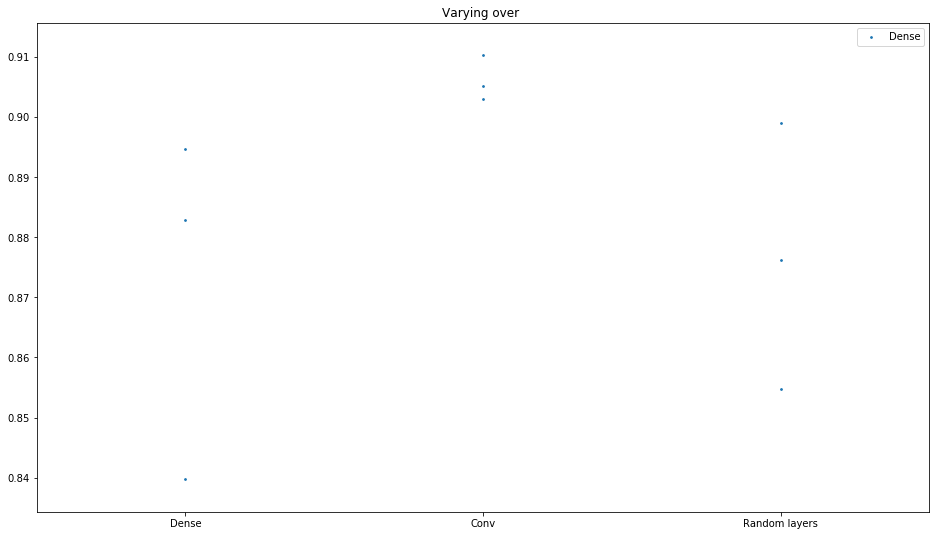

In [22]:
plotter.plot_marginals(
    data,
    dimension_meaning,
    values,
    0
)